In [1]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
import pickle

# from utils import get_def_name, get_tags_from_first_tiff, get_tiff_list
from utils import *
from multi_threading import read_all_images, parallel_sum
from plotting import plot_SUM_or_RMS

# debugging = [True]
configs = dict(debugging=False, 
                  pickle_usage=True, 
                  tiff_amount_cutoff=None
                  )

##### Testing block for cProfile

In [2]:
# import cProfile

# def profile_read_image(file_path):
#     profiler = cProfile.Profile()
#     profiler.enable()

#     # 调用你想要分析的函数
#     # result = read_image(file_path)
#     result = to_call_with_cProfile(file_path=file_path)

#     profiler.disable()
#     profiler.print_stats(sort='time')

#     return result

# def to_call_with_cProfile(**args):
#     file_path = args['file_path']
    
#     result = read_image(file_path)

#     return result

# 使用你的文件路径调用函数
# example_tiff =  'C:\\3.12 qCMOS\\full frame\\Background001.tif'
# profile_read_image(example_tiff)

##### Keep going

In [3]:
@timer_decorator(configs)
def get_sum_array_dense(tiff_path, configs):
    # # if debugging is not yet defined in global, set it to be True
    # if 'debugging' not in globals():
    #     debugging = True
    # debugging = kwargs.get('debugging', False)
    # pickle_usage = kwargs.get('pickle_usage', True)

    debugging = configs['debugging']
    pickle_usage = configs['pickle_usage']

    # image_arrays = read_all_images(tiff_path, **kwargs)
    image_arrays = read_all_images(tiff_path, configs)
    if debugging==True and pickle_usage==False:
        print('NOT USING PICKLE')
    
    if os.path.exists(f'{tiff_path}\\sum_image_arrays.pkl') and pickle_usage==True:
        with open(f'{tiff_path}\\sum_image_arrays.pkl', 'rb') as f:
            sum_array = pickle.load(f)
        print('Loaded sum_image_arrays.pkl')

    else:
        # sum_array = np.zeros_like(image_arrays[0], dtype=np.float64)
        # for img in image_arrays:
        #     sum_array += img
        sum_array_csr = parallel_sum(image_arrays)

        sum_array = sum_array_csr.toarray()
        if pickle_usage==True:
            with open(f'{tiff_path}\\sum_image_arrays.pkl', 'wb') as f:
                pickle.dump(sum_array, f)

    return sum_array

In [4]:
# def SUM_captions():
#     caption_statistics_SUM = f'{np.sum(sum_array==0)} pixels had 0 count in the whole set of data, {np.sum(sum_array==0) / total_pixel_amount * 100:.1f}%; \n' + \
#             f'SUM(10% of the pixels) <= {np.percentile(sum_array, 10)}; \n' + \
#             f'SUM(90% of the pixels) <= {np.percentile(sum_array, 90)}'
#     figname_optional = ''
#     return caption_statistics_SUM

# @timer_decorator
# def plot_SUM(sum_array, tiff_path, **kwargs):
#     plot_type = kwargs.get('plot_type', 'bar')
#     # debugging = kwargs.get('debug', True)
# #     debugging = kwargs.get('debugging', True)
#     bin_amount = kwargs.get('bin_amount', 100)
#     heatmap_max = kwargs.get('heatmap_max')
#     save = kwargs.get('save', False)

#     tiff_filenames = get_tiff_list(tiff_path)

#     # sum_image_arrays = sum_image_arrays.toarray()


#     caption_tags, image_width, image_length, exposure_time_ms = get_tags_from_first_tiff(tiff_path)[:4]
#     total_pixel_amount = image_width * image_length

#     caption_statistics_SUM = f'{np.sum(sum_array==0)} pixels had 0 count in the whole set of data, {np.sum(sum_array==0) / total_pixel_amount * 100:.1f}%; \n' + \
#             f'SUM(10% of the pixels) <= {np.percentile(sum_array, 10)}; \n' + \
#             f'SUM(90% of the pixels) <= {np.percentile(sum_array, 90)}'

#     # caption_statistics_SUM = SUM_captions()
#     figname_optional = ''


#     if plot_type == 'bar':
#         # It was cutting right tail of the histogram. Name a max for it
#         # counts, bin_edges = np.histogram(sum_image_arrays.flatten(), bins=bin_amount)
#         min_value = 0
#         max_value = np.max(sum_array)
#         counts, bin_edges = np.histogram(sum_array.flatten(), bins=bin_amount, range=(min_value, max_value))

#         if debugging==True:
#             # print(f'bin amount: {bin_amount}')
#             print(f'bins width: {np.average(np.diff(bin_edges))}')
#             max_fraction_bin = np.max(counts) / np.sum(counts)
#             print(f'{100*max_fraction_bin:.1f}% of pixel Sum counts fall between '
#                 f'{np.argmax(counts)} and {np.argmax(counts) + np.diff(bin_edges)[0]} counts in all {len(tiff_filenames)} frames')

#         # counts_normalized = counts / counts.max()

#         fig = plt.figure(figsize=(10, 6))
#         # plt.bar(bin_edges[:-1], counts_normalized, width=np.diff(bin_edges), color='gray', log=True, align='edge')
#         plt.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), color='gray', log=True, align='edge')

#         plt.xlabel('Total Counts')
#         plt.ylabel('Frequency')

#         figname_optional += f'_{len(tiff_filenames)}frames'

#         fig.text(0.15, 0.05, caption_tags + caption_statistics_SUM, ha='left')
#         plt.subplots_adjust(bottom=0.25)

#     elif plot_type == 'heat':
#         heat_plot_width = np.round(image_width/image_length * 6, 1) + 2
#         fig = plt.figure(figsize=(heat_plot_width, 6), dpi=400)

#         plt.imshow(sum_array, cmap='hot', interpolation='nearest', vmax=heatmap_max)
#         # plt.imshow(sum_image_arrays, cmap='hot')
#         plt.colorbar(label='Counts (Sum)')
#         # check whether heatmap_max is None:
#         if heatmap_max is not None:
#         # if so add a caption to the caption_tags, declaring all values above heatmap_max are clipped
#             caption_tags += f'Clipped at {heatmap_max} counts\n'
#             figname_optional += f'_clip{heatmap_max}'

#         figname_optional += f'_{len(tiff_filenames)}frames'
        
#         fig.text(0.15, 0.05, caption_tags + caption_statistics_SUM, ha='left')
#         plt.subplots_adjust(bottom=0.25)


#     if save==True:
#         plt.savefig(f'SUM_{plot_type}{figname_optional}_{exposure_time_ms}ms_{image_width}x{image_length}.png')
#     plt.show()

#### Testing

In [5]:
# tiff_main_folder = 'C:\\LABDATA_office\\3.12 qCMOS'


# tiff_path = tiff_main_folder + '\\full_1s_6000_shot'
# tiff_path = tiff_main_folder + '\\full_frame_quick'
# tiff_path = tiff_main_folder + '\\full_frame'
# tiff_path = tiff_main_folder + '\\full_200ms_6247shots'
# tiff_path = tiff_main_folder + '\\full_5s_2000shots'
# tiff_path = tiff_main_folder + '\\full_5s_6000shots'
# tiff_path = tiff_main_folder + '\\full_200ms_6000shots_cutfrom6247'
# tiff_path = tiff_main_folder + '\\full_200ms_2000shots_cutfrom6247'


# SUM_array = get_sum_array_dense(tiff_path, debugging=True)
# print('Max element:', SUM_array.max())
# print('Min element:', SUM_array.min())

# plot_SUM(SUM_array, tiff_path, plot_type='heat', save=True, heatmap_max=240)
# plot_SUM(SUM_array, tiff_path, plot_type='bar', save=True)

#### 4.1 Laser Fluctuation

Loaded sum_image_arrays.pkl


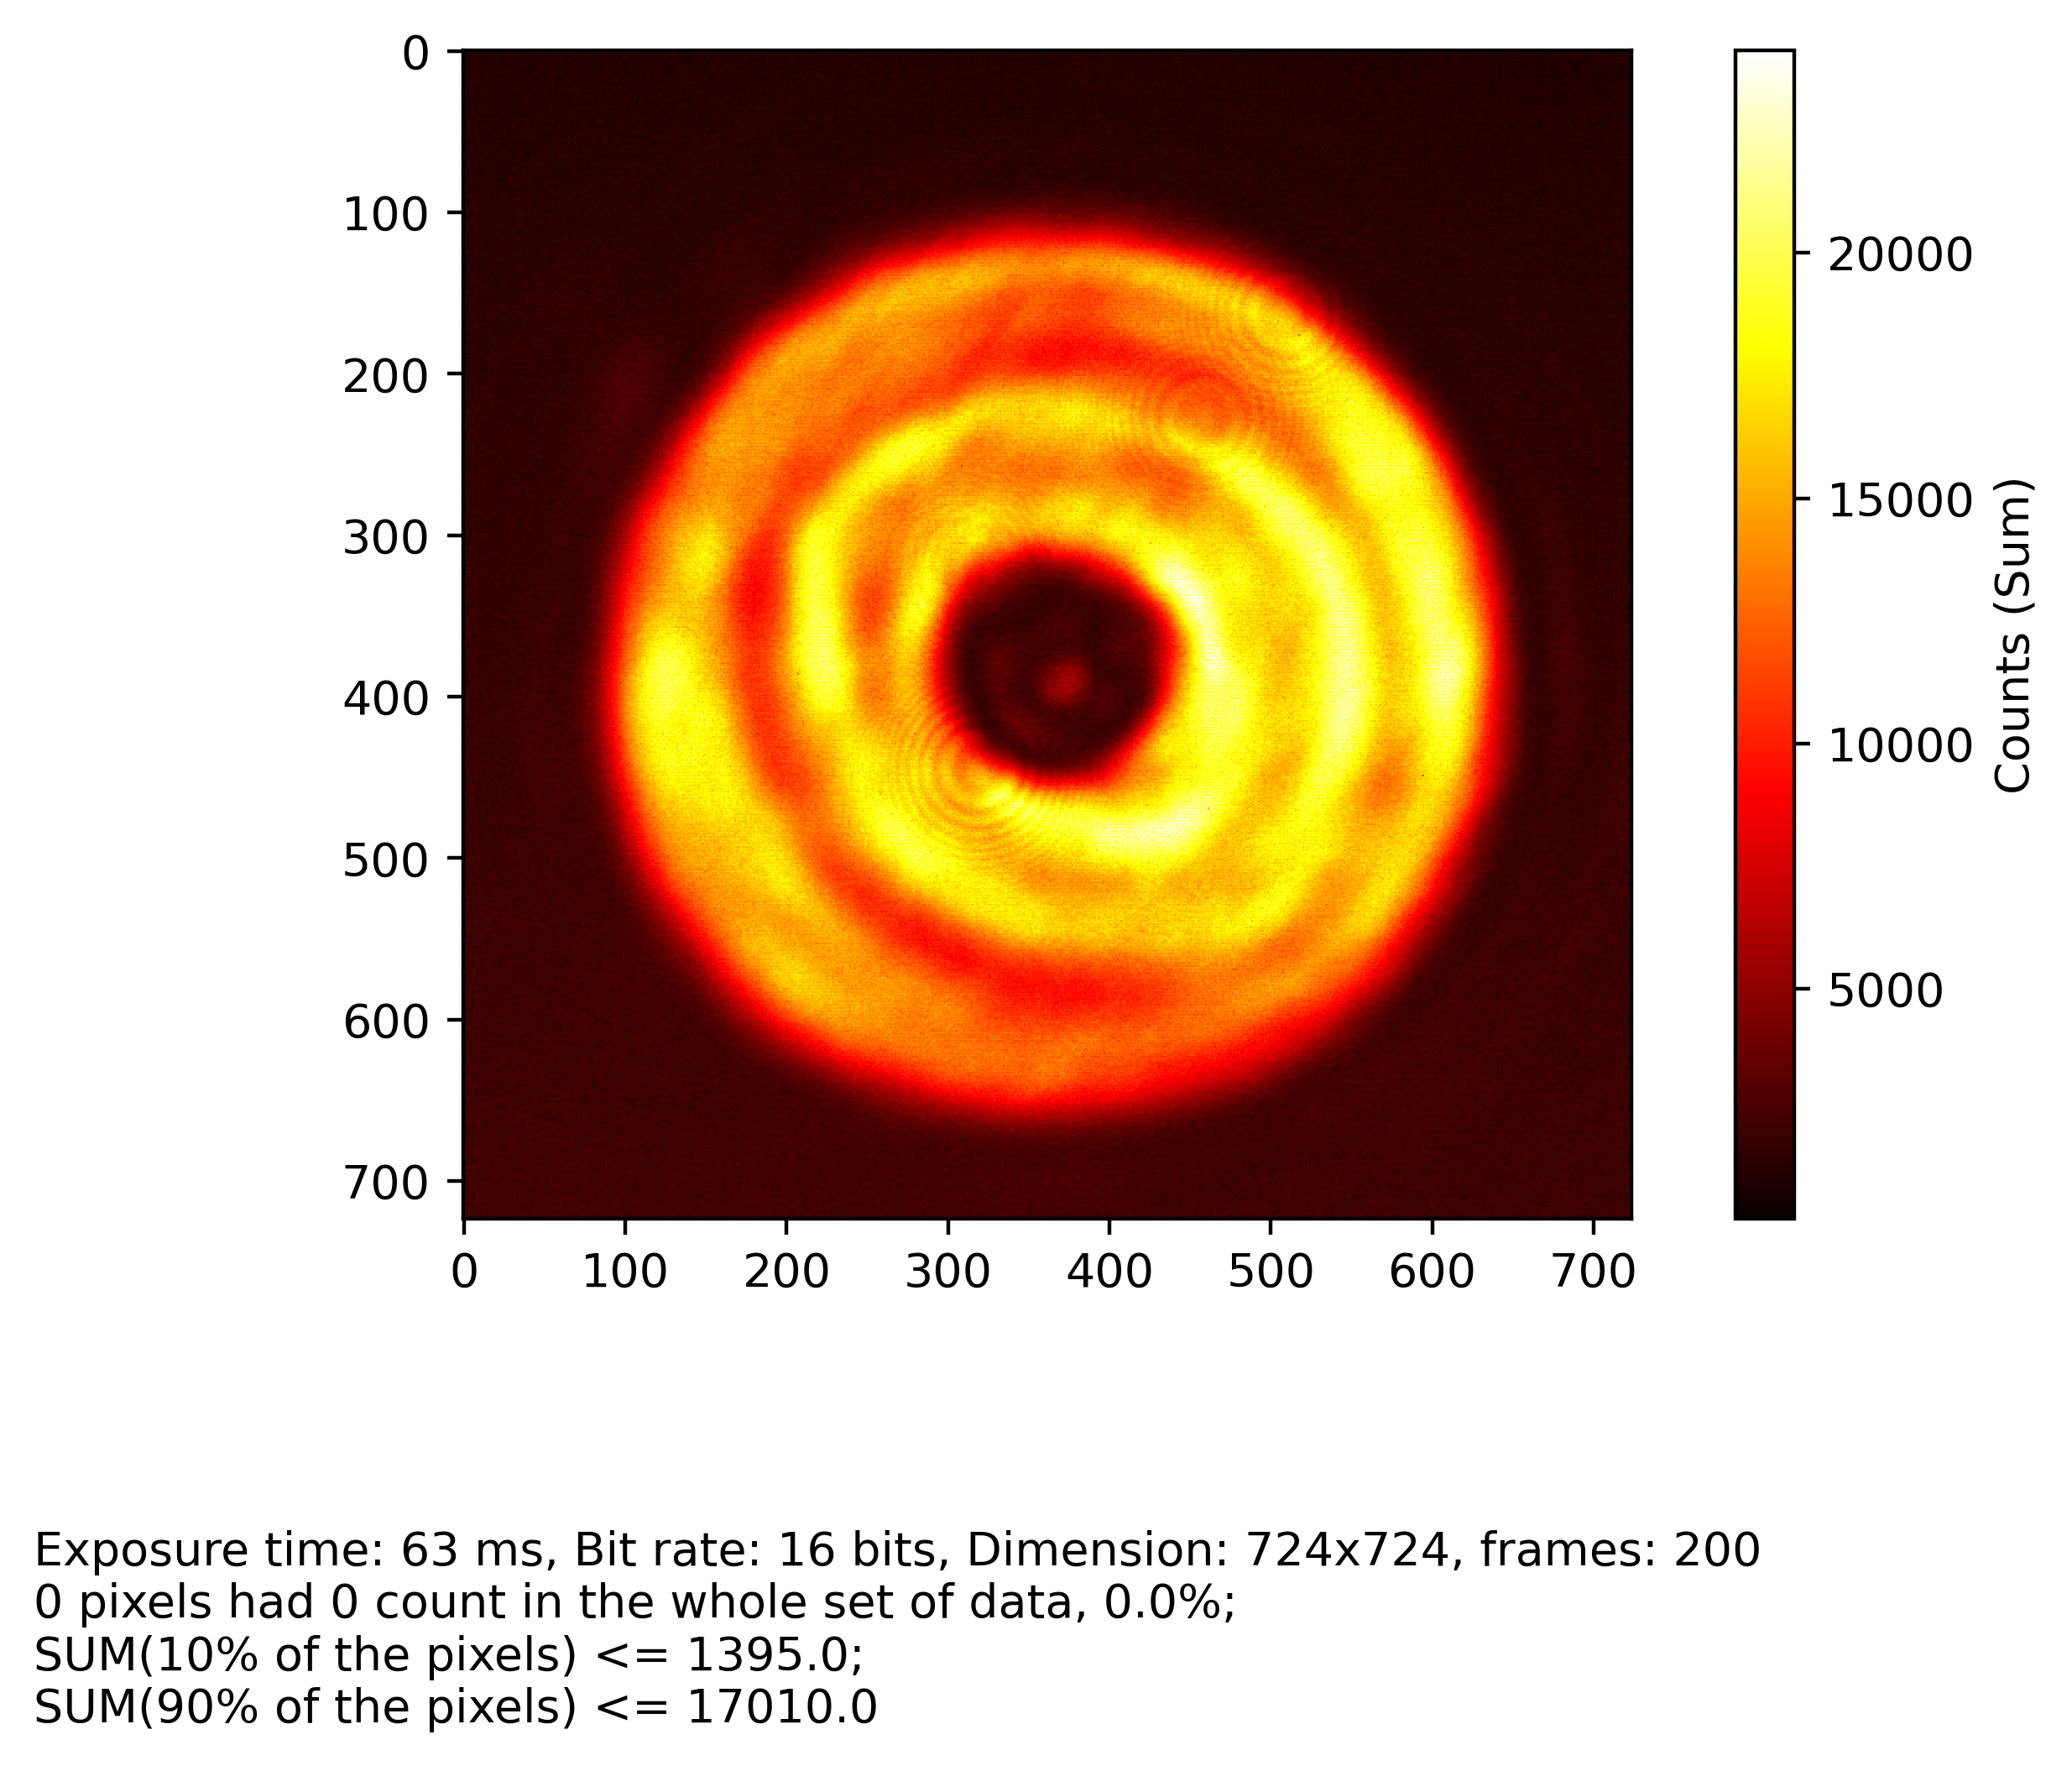

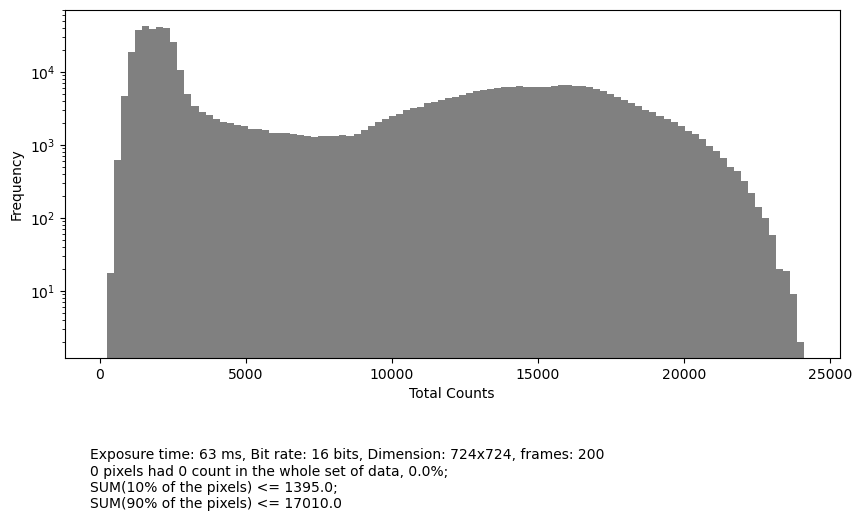

In [6]:
tiff_main_folder = 'C:\\LABDATA_office\\4.1'
tiff_path = tiff_main_folder + '\\data'

SUM_array = get_sum_array_dense(tiff_path, configs)

plot_SUM_or_RMS(SUM_array, tiff_path, configs, plot_type='heat', save=True, array_type='SUM', heatmap_max=None)
# plot_SUM_or_RMS(SUM_array, tiff_path, configs, plot_type='bar', save=True, array_type='SUM')